# Analysis of chemo diversity on pharmacological and biological activities

The [dataset](results/activities_2022-01-29_16-33-05.csv) is obtained from the Scopus downloader version 2.0 from the [base set](data/activities.csv) of chemical compounds and activities.

**TODO** check:

- <https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe>
- <https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#multiindex-query-syntax>


## Loading data obtained from Scopus

### Boilerplate

Some Python configuration.


In [1]:
from pathlib import Path
from itertools import islice, product
from pprint import pprint

import pandas as pd
import numpy as np
import numpy.typing as npt
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
import scopus.biblio_extractor as bex
import catk

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 20)
pd.set_option("display.min_rows", 10)

# (11.7, 8.27) = A4 landscape
# sns.set_theme(style="dark", palette="muted", font_scale=1.10, rc={"figure.figsize": (16.54, 11.7)})
sns.set_theme(style="dark", palette="muted", font_scale=1.10, rc={"figure.figsize": (23.4, 16.54)})

DATASET_FILENAME = Path("results/pharmaco_chemistry_2_cross_2022-10-24_15-57-13.csv")
# DATASET_FILENAME = Path("results/pharmaco_chemistry_2_cross_2022-10-06_18-16-36.csv")
# DATASET_FILENAME = Path("results/pharmaco_chemistry_cross_2022-05-19_17-18-20.csv")
# DATASET_FILENAME = Path("results/activities_2022-01-29_16-33-05.csv")
print(f"{DATASET_FILENAME.stem = } {DATASET_FILENAME.suffix = }")

SEED = 42


'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/data/data.py' loaded
'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/data/__init__.py' loaded
'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/ca.py' loaded
'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/__init__.py' loaded
DATASET_FILENAME.stem = 'pharmaco_chemistry_2_cross_2022-10-24_15-57-13' DATASET_FILENAME.suffix = '.csv'


In [2]:
def name_shortener(name, *, max_len=24, padding="…"):
    if len(name) <= max_len:
        return name
    first_alt = name.split(bex.ALT_SEP)[0]
    if len(first_alt) <= max_len:
        return f"{first_alt}{bex.ALT_SEP}{padding}"

    return f"{first_alt[:max_len]}{padding}"


print(name_shortener("heat/resistance"))
print(name_shortener("heat stress/heat tolerance/heat resistance"))
print(name_shortener("heavy heat important stress/heat tolerance/heat resistance"))


def df_shortener(df):
    res = df.copy()
    new_idx = pd.MultiIndex.from_tuples([tuple(name_shortener(x) for x in idx) for idx in df.index])
    new_col = pd.MultiIndex.from_tuples([tuple(name_shortener(x) for x in idx) for idx in df.columns])
    res.index = new_idx
    res.columns = new_col
    return res


def series_shortener(ser):
    res = ser.copy()
    new_idx = pd.MultiIndex.from_tuples([tuple(name_shortener(x) for x in idx) for idx in ser.index])
    res.index = new_idx
    return res


heat/resistance
heat stress/...
heavy heat important str...


### Loading the CSV file

Now, we load the dataset we'll use in this Notebook. It is generated using [our tool](biblio_extractor.py) in the same repository.
The dataset is a 106 \* 66 matrix, with rows and columns indexed by three levels (using Pandas's `MultiIndex`) as follows:

- level 0 is _class_ (chemical, biological or pharmacological class)
- level 1 is _name_ (compound or activity, a.k.a. keyword)
- level 2 is _kind_ (either _w/o_ for _without_ or _w/_ for _with_)

The matrix is indexed by _two_ disjoint finite sets of keywords:

- **rows**: a set of 53 (chemical) coumpounds = {acridine, triterpene, ...}
- **columns**: a set of 33 (biological, pharmacological) activities = {germination, cytotoxicity, ...}

An example is shown below, restricted to two compounds and two activities.
Note that this is **not** an extract of the whole dataset, the (w/o, w/o) cells being smaller here.

|                   |            |     | germination | germination | cytotoxicity | cytotoxicity |
| ----------------- | ---------- | --- | ----------- | ----------- | ------------ | ------------ |
|                   |            |     | allelopathy | allelopathy | pharmaco     | pharmaco     |
|                   |            |     | w/o         | w/          | w/o          | w/           |
| alkaloid          | acridine   | w/o | 2100        | 32          | 28           | 2104         |
| alkaloid          | acridine   | w/  | 1294        | 11          | 9            | 1296         |
| terpenoid/terpene | triterpene | w/o | 1283        | 11          | 9            | 1285         |
| terpenoid/terpene | triterpene | w/  | 2111        | 32          | 28           | 2115         |

Let $M$ be this matrix, and for each couple of keywords made of a compound and and activity, call $M_{ij} = (c_i, a_j)$, the **ij confusion submatrix**.
Assume that $M_{ij}$ is of the form :
\begin{bmatrix}
FF & FT\\
TF & TT
\end{bmatrix}

Where :

- $FF = (\text{w/o}, \text{w/o})$ is the number of papers that have **neither** the $c_i$ compound **nor** the $a_j$ activity;
- $FT = (\text{w/o}, \text{w/})$ is the number of papers that have the $a_j$ activity but **not** the $c_i$ compound;
- $TF = (\text{w/}, \text{w/o})$ is the number of papers that have the $c_i$ compound but **not** the $a_j$ activity;
- $TT = (\text{w/}, \text{w/})$ is the number of papers that have **both** the $c_i$ compound **and** the $a_j$ activity.

We avoid the open world hypothesis by restricting the analysis to the paper in the domain $D$,
which is the set of papers that have at least one compound and one activity.
By construction:

- $FF + FT$ and $TF + TT$ are constants for each $c_i$ (whatever the choice of $a_j$) and is the total number of papers in $D$ with the $c_i$ comppound;
- $FF + TF$ and $FT + TT$ are constants for each $a_j$ (whatever the choice of $c_i$) and is the total number of papers in $D$ with the $a_j$ activity.
- thus each confusion matrix $M_{ij}$ is such that $FF + FT + TF + TT = |D|$ where $|D|$ is _the total number of paper_ under scrutiny.


In [3]:
dataset, margin_rows, margin_cols, number_of_papers = bex.load_results(DATASET_FILENAME)
all_compounds = set(dataset.index.get_level_values(1))
all_activities = set(dataset.columns.get_level_values(1))

print(f"The domain contains {number_of_papers} papers")

display(df_shortener(dataset))
display(series_shortener(margin_rows))
display(series_shortener(margin_cols))


The domain contains 439830 papers


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 
 heat stress/... 
 heavy metal stress/... 
 hydric stress/... 
 ... 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 
 w/o 
 w/ 
 w/o 
 w/ 
 w/o 
 ... 
 w/ 
 w/o 
 w/ 
 w/o 
 w/ 
 
 
 
 
 alkaloid 
 benzylamine 
 w/o 
 435715 
 3144 
 438336 
 523 
 436331 
 ... 
 15441 
 427082 
 11777 
 381684 
 57175 
 
 
 w/ 
 967 
 4 
 971 
 0 
 971 
 ... 
 72 
 951 
 20 
 801 
 170 
 
 
 colchicine 
 w/o 
 427287 
 3118 
 429882 
 523 
 427896 
 ... 
 15107 
 418931 
 11474 
 374687 
 55718 
 
 
 w/ 
 9395 
 30 
 9425 
 0 
 9406 
 ... 
 406 
 9102 
 323 
 7798 
 1627 
 
 
 cyclopeptide 
 w/o 
 433182 
 3143 
 435804 
 521 
 433799 
 ... 
 15413 
 424595 
 11730 
 379416 
 56909 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 sesterterpene 
 w/ 
 285 
 0 
 285 
 0 
 285 
 ... 
 4 
 283 
 2 
 266 
 19 
 
 
 tetraterpene/... 
 w/o 
 400136 
 2613 
 402347 
 402 
 401105 
 ... 
 15409 
 391144 
 11605 
 347508 
 55241 
 
 
 w/ 
 36546 
 535 
 36960 
 121 
 36197 
 ... 
 104 
 36889 
 192 
 34977 
 2104 
 
 
 triterpene/saponin 
 w/o 
 412755 
 3074 
 415309 
 520 
 413340 
 ... 
 14432 
 405055 
 10774 
 362184 
 53645 
 
 
 w/ 
 23927 
 74 
 23998 
 3 
 23962 
 ... 
 1081 
 22978 
 1023 
 20301 
 3700 
 
 
 
 108 rows × 74 columns

alkaloid           benzylamine         w/o    438859
                                       w/        971
                   colchicine          w/o    430405
                                       w/       9425
                   cyclopeptide        w/o    436325
                                               ...  
terpenoid/terpene  sesterterpene       w/        285
                   tetraterpene/...    w/o    402749
                                       w/      37081
                   triterpene/saponin  w/o    415829
                                       w/      24001
Name: (*, Σ, w/), Length: 108, dtype: int64

abiotic   heat stress/...         w/o    436682
                                  w/       3148
          heavy metal stress/...  w/o    439307
                                  w/        523
          hydric stress/...       w/o    437302
                                          ...  
pharmaco  sedative/analgesic      w/      15513
          wound                   w/o    428033
                                  w/      11797
toxicity  toxicity                w/o    382485
                                  w/      57345
Name: (*, Σ, w/), Length: 74, dtype: int64

### Extractiong the  "w/, w/o" matrix

We can extract the 53\*33 matrix we use in the version version of this software, where we had only the with/with queries.
In our small running example, that would be:

|                   |            | germination | cytotoxicity |
| ----------------- | ---------- | ----------- | ------------ |
|                   |            | allelopathy | pharmaco     |
| alkaloid          | acridine   | 11          | 1296         |
| terpenoid/terpene | triterpene | 32          | 2115         |


In [4]:
with_with_matrix = dataset.xs("w/", level=2).xs("w/", level=2, axis=1)
display(with_with_matrix)


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ph stress/ph tolerance/ph resistance/ph impact/ph change 
 salt stress/salinity stress/salt tolerance/salinity tolerance/salt resistance/salinity resistance/salt impact/salinity impact/salt change/salinity change 
 ... 
 obesity 
 rheumatism 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 alkaloid 
 benzylamine 
 4 
 0 
 0 
 3 
 6 
 ... 
 51 
 0 
 72 
 20 
 170 
 
 
 colchicine 
 30 
 0 
 19 
 3 
 15 
 ... 
 235 
 109 
 406 
 323 
 1627 
 
 
 cyclopeptide 
 5 
 2 
 2 
 2 
 6 
 ... 
 60 
 32 
 100 
 67 
 436 
 
 
 imidazole 
 149 
 3 
 8 
 76 
 35 
 ... 
 388 
 6 
 1419 
 658 
 3866 
 
 
 indole 
 194 
 84 
 344 
 70 
 571 
 ... 
 493 
 31 
 1284 
 642 
 4160 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 polyterpene 
 0 
 0 
 0 
 0 
 0 
 ... 
 0 
 0 
 0 
 0 
 2 
 
 
 sesquiterpene 
 36 
 0 
 42 
 0 
 24 
 ... 
 108 
 53 
 336 
 297 
 1480 
 
 
 sesterterpene 
 0 
 0 
 0 
 0 
 0 
 ... 
 2 
 1 
 4 
 2 
 19 
 
 
 tetraterpene/carotenoid/xanthophyll 
 535 
 121 
 884 
 44 
 1167 
 ... 
 654 
 11 
 104 
 192 
 2104 
 
 
 triterpene/saponin 
 74 
 3 
 39 
 8 
 38 
 ... 
 563 
 173 
 1081 
 1023 
 3700 
 
 
 
 54 rows × 37 columns

## Analyzing data

### Extracting the (confusion) submatrices

Lets illustrate the content of this table. The **2 by 2 submatrix** about _colchicine_ and _cytotoxicity_ is as follows.


In [5]:
example_submatrix = dataset.loc[
    ("alkaloid", "colchicine"),
    ("pharmaco", "cytotoxicity"),
]
print(f"Among {number_of_papers} papers, there are")
for i, j in product(bex.SELECTORS, bex.SELECTORS):
    print(f"- {example_submatrix.loc[i,j]} papers {i} acridine and {j} cytotoxicity in their keywords")

print("The colchicine and cytotoxicity confusion matrix is as follows")
display(example_submatrix)


Among 439830 papers, there are
- 372674 papers w/o acridine and w/o cytotoxicity in their keywords
- 57731 papers w/o acridine and w/ cytotoxicity in their keywords
- 7754 papers w/ acridine and w/o cytotoxicity in their keywords
- 1671 papers w/ acridine and w/ cytotoxicity in their keywords
The colchicine and cytotoxicity confusion matrix is as follows


,w/o,w/
w/o,372674,57731
w/,7754,1671


### Metrics

We given different metrics to be applied on 2x2 submatrices, see the usual one for _confusion matrix_ in <https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion>

In [6]:
# def intersection_metric(arr):
#     """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
#     [FF, FT], [TF, TT] = arr.reshape(2, 2)
#     return TT / (FF + FT + TF + TT)


def tt_projection_metric(arr):
    """The trivial one. Just keep the bottom right cell. Amount to compute on "the old matrix" """
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT


def row_implication_metric(arr):
    """The % of paper that have both keywords among the first one. Values add to 1 row wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (TF + TT)


def col_implication_metric(arr):
    """The % of paper that have both keywords among the second one. Values add to 1 col wise"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TT)


def fowlkes_mallows_metric(arr):
    """Computes the Fowlkes-Mallows index: sqrt(the product of row and col implication)"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / np.sqrt((FT + TT) * (TF + TT))


def accuracy_metric(arr):
    """Computes the accuracy"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (TT + FF) / (FF + FT + TF + TT)


def x_metric(arr):
    """Some another one by our own"""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF + TT - FT - TF) / (FF + FT + TF + TT)


def fraction_metric(arr):
    """The % of paper that have both keywords among the ones having at least one."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return TT / (FT + TF - TT)


def odds_metric(arr):
    """The odds of having related keywords."""
    [FF, FT], [TF, TT] = arr.reshape(2, 2)
    return (FF * TT + 0.5) / (FT * TF + 0.5)


def logodds_metric(arr):
    """The log odds of having related keywords."""
    return np.log(odds_metric(arr))


metrics = [
    tt_projection_metric,
    row_implication_metric,
    col_implication_metric,
    fowlkes_mallows_metric,
    fraction_metric,
    odds_metric,
    accuracy_metric,
    # logodds_metric,
]


print("An example on the colchicine/cytotoxicity submatrix, its score for each metric")
print(example_submatrix)

for metric in metrics:
    print(f"- {metric.__name__:<22} = {metric(example_submatrix.values)}")


An example on the colchicine/cytotoxicity submatrix, its score for each metric
        w/o     w/
w/o  372674  57731
w/     7754   1671
- tt_projection_metric   = 1671
- row_implication_metric = 0.17729442970822282
- col_implication_metric = 0.028130365980943404
- fowlkes_mallows_metric = 0.07062122339690069
- fraction_metric        = 0.026185476541197857
- odds_metric            = 1.3911394533764747
- accuracy_metric        = 0.8511129299956801


### Applying the metrics

First, we filter out rows and cols with too few papers, we ask for at leat 0.1% of the total number of papers.
From now on, we'll stick to the **filtered dataset**.

In [7]:
ROW_THRESHOLD = number_of_papers // 1000
COL_THRESHOLD = number_of_papers // 1000
print(f"Thresholds for rows={ROW_THRESHOLD} and cols={COL_THRESHOLD}")

rows_filter = margin_rows.xs(bex.SELECTORS[1], level=2) >= ROW_THRESHOLD
cols_filter = margin_cols.xs(bex.SELECTORS[1], level=2) >= COL_THRESHOLD
filtered = dataset.loc[rows_filter, cols_filter]
filtered.index.name = "Compounds"
filtered.columns.name = "Activities"
display(filtered)

Thresholds for rows=439 and cols=439


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ... 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 
 w/o 
 w/ 
 w/o 
 w/ 
 w/o 
 ... 
 w/ 
 w/o 
 w/ 
 w/o 
 w/ 
 
 
 
 
 alkaloid 
 benzylamine 
 w/o 
 435715 
 3144 
 438336 
 523 
 436331 
 ... 
 15441 
 427082 
 11777 
 381684 
 57175 
 
 
 w/ 
 967 
 4 
 971 
 0 
 971 
 ... 
 72 
 951 
 20 
 801 
 170 
 
 
 colchicine 
 w/o 
 427287 
 3118 
 429882 
 523 
 427896 
 ... 
 15107 
 418931 
 11474 
 374687 
 55718 
 
 
 w/ 
 9395 
 30 
 9425 
 0 
 9406 
 ... 
 406 
 9102 
 323 
 7798 
 1627 
 
 
 cyclopeptide 
 w/o 
 433182 
 3143 
 435804 
 521 
 433799 
 ... 
 15413 
 424595 
 11730 
 379416 
 56909 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 sesquiterpene 
 w/ 
 11850 
 36 
 11886 
 0 
 11844 
 ... 
 336 
 11589 
 297 
 10406 
 1480 
 
 
 tetraterpene/carotenoid/xanthophyll 
 w/o 
 400136 
 2613 
 402347 
 402 
 401105 
 ... 
 15409 
 391144 
 11605 
 347508 
 55241 
 
 
 w/ 
 36546 
 535 
 36960 
 121 
 36197 
 ... 
 104 
 36889 
 192 
 34977 
 2104 
 
 
 triterpene/saponin 
 w/o 
 412755 
 3074 
 415309 
 520 
 413340 
 ... 
 14432 
 405055 
 10774 
 362184 
 53645 
 
 
 w/ 
 23927 
 74 
 23998 
 3 
 23962 
 ... 
 1081 
 22978 
 1023 
 20301 
 3700 
 
 
 
 88 rows × 70 columns

For instance, let's apply the _row_implication_metric_ to the filtered dataset.

In [8]:
def apply_metric(data, func, write=False):
    C, A = len(data.index) // 2, len(data.columns) // 2
    values = np.moveaxis(data.values.reshape((C, 2, A, 2)), 1, -2).reshape((C * A, 4))
    matrix = np.apply_along_axis(func, 1, values).reshape((C, A))
    sub = data.xs(bex.SELECTORS[True], axis=0, level=2).xs(bex.SELECTORS[True], axis=1, level=2)
    df = pd.DataFrame(matrix, index=sub.index, columns=sub.columns)
    df.index.name = "Compounds"
    df.columns.name = "Activities"

    if write:
        filename = Path(f"{DATASET_FILENAME.stem}_{func.__namme__}{DATASET_FILENAME.suffix}")
        df.to_csv(Path("results") / filename)
    return df


apply_metric(filtered, odds_metric)


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ph stress/ph tolerance/ph resistance/ph impact/ph change 
 salt stress/salinity stress/salt tolerance/salinity tolerance/salt resistance/salinity resistance/salt impact/salinity impact/salt change/salinity change 
 ... 
 obesity 
 rheumatism 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 alkaloid 
 benzylamine 
 0.573 
 0.000 
 0.000 
 1.706 
 0.754 
 ... 
 2.189 
 0.000 
 2.196 
 0.763 
 1.417 
 
 
 colchicine 
 0.438 
 0.000 
 0.344 
 0.172 
 0.190 
 ... 
 1.008 
 7.152 
 1.238 
 1.296 
 1.403 
 
 
 cyclopeptide 
 0.197 
 0.478 
 0.098 
 0.312 
 0.207 
 ... 
 0.684 
 5.145 
 0.802 
 0.705 
 0.947 
 
 
 imidazole 
 0.923 
 0.107 
 0.059 
 1.956 
 0.181 
 ... 
 0.681 
 0.138 
 1.929 
 1.100 
 1.414 
 
 
 indole 
 1.005 
 2.935 
 2.430 
 1.471 
 2.932 
 ... 
 0.721 
 0.607 
 1.401 
 0.878 
 1.234 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 diterpene 
 0.404 
 0.000 
 0.369 
 0.106 
 0.282 
 ... 
 0.408 
 2.698 
 1.040 
 0.987 
 0.987 
 
 
 monoterpene 
 2.019 
 0.277 
 3.508 
 0.181 
 0.442 
 ... 
 0.261 
 3.107 
 1.486 
 0.975 
 1.109 
 
 
 sesquiterpene 
 0.415 
 0.000 
 0.607 
 0.000 
 0.240 
 ... 
 0.355 
 2.521 
 0.791 
 0.928 
 0.947 
 
 
 tetraterpene/carotenoid/xanthophyll 
 2.242 
 3.277 
 5.958 
 0.633 
 5.358 
 ... 
 0.689 
 0.149 
 0.071 
 0.175 
 0.378 
 
 
 triterpene/saponin 
 0.415 
 0.100 
 0.270 
 0.175 
 0.184 
 ... 
 0.943 
 4.717 
 1.312 
 1.674 
 1.231 
 
 
 
 44 rows × 35 columns

Now, compute all given metrics with a short summary.

In [9]:
score_df = {}
for metric in metrics:
    metric_name = metric.__name__
    score_df[metric_name] = apply_metric(filtered, metric, False)


scores_summary_df = pd.DataFrame.from_dict(
    {f_name: [df.values.min(), df.values.mean(), df.values.max(), df.values.std()] for f_name, df in score_df.items()},
    orient="index",
    columns=["min", "mean", "max", "std"],
)


scores_summary_df


,min,mean,max,std
tt_projection_metric,0.000,490.203,55613.000,1972.029
row_implication_metric,0.000,0.040,0.718,0.071
col_implication_metric,0.000,0.028,0.782,0.057
fowlkes_mallows_metric,0.000,0.023,0.563,0.040
fraction_metric,0.000,0.012,1.813,0.058
odds_metric,0.000,1.316,125.621,3.882
accuracy_metric,0.683,0.935,0.998,0.061


### Correspondance Analysis

Here, we implement Correspondance Analysis from scratch using SVD from from `scipy.linalg`.
We explore the results on all previous metrics.

Now, we draw compounds and activities as scatterplots on the first 2 dimensions. For this one, we use the `catk` lib without further ado.

In [10]:
ca = catk.ca.CA(SEED)
# score_df["tt_projection_metric"]
score_df["odds_metric"]


abiotic 
 ... 
 pharmaco 
 toxicity 
 
 
 
 
 heat stress/heat tolerance/heat resistance/heat impact/heat change/temperature stress/temperature tolerance/temperature resistance/temperature impact/temperature change 
 heavy metal stress/metallic trace element stress/heavy metal tolerance/metallic trace element tolerance/heavy metal resistance/metallic trace element resistance/heavy metal impact/metallic trace element impact/heavy metal change/metallic trace element change 
 hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change 
 ph stress/ph tolerance/ph resistance/ph impact/ph change 
 salt stress/salinity stress/salt tolerance/salinity tolerance/salt resistance/salinity resistance/salt impact/salinity impact/salt change/salinity change 
 ... 
 obesity 
 rheumatism 
 sedative/analgesic 
 wound 
 toxicity 
 
 
 
 
 alkaloid 
 benzylamine 
 0.573 
 0.000 
 0.000 
 1.706 
 0.754 
 ... 
 2.189 
 0.000 
 2.196 
 0.763 
 1.417 
 
 
 colchicine 
 0.438 
 0.000 
 0.344 
 0.172 
 0.190 
 ... 
 1.008 
 7.152 
 1.238 
 1.296 
 1.403 
 
 
 cyclopeptide 
 0.197 
 0.478 
 0.098 
 0.312 
 0.207 
 ... 
 0.684 
 5.145 
 0.802 
 0.705 
 0.947 
 
 
 imidazole 
 0.923 
 0.107 
 0.059 
 1.956 
 0.181 
 ... 
 0.681 
 0.138 
 1.929 
 1.100 
 1.414 
 
 
 indole 
 1.005 
 2.935 
 2.430 
 1.471 
 2.932 
 ... 
 0.721 
 0.607 
 1.401 
 0.878 
 1.234 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 terpenoid/terpene 
 diterpene 
 0.404 
 0.000 
 0.369 
 0.106 
 0.282 
 ... 
 0.408 
 2.698 
 1.040 
 0.987 
 0.987 
 
 
 monoterpene 
 2.019 
 0.277 
 3.508 
 0.181 
 0.442 
 ... 
 0.261 
 3.107 
 1.486 
 0.975 
 1.109 
 
 
 sesquiterpene 
 0.415 
 0.000 
 0.607 
 0.000 
 0.240 
 ... 
 0.355 
 2.521 
 0.791 
 0.928 
 0.947 
 
 
 tetraterpene/carotenoid/xanthophyll 
 2.242 
 3.277 
 5.958 
 0.633 
 5.358 
 ... 
 0.689 
 0.149 
 0.071 
 0.175 
 0.378 
 
 
 triterpene/saponin 
 0.415 
 0.100 
 0.270 
 0.175 
 0.184 
 ... 
 0.943 
 4.717 
 1.312 
 1.674 
 1.231 
 
 
 
 44 rows × 35 columns

In [16]:
base_ca_df = df_shortener(score_df["odds_metric"])
ca.fit(base_ca_df)
display(ca.axes())
display(ca.contributions(K = 2))

# ca.plot(coords=("standard", "standard"))
# plt.show()


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.687,1392.645,23.116,23.116
2,0.395,801.063,13.296,36.412
3,0.251,508.824,8.446,44.858
4,0.212,429.211,7.124,51.982
5,0.208,421.137,6.990,58.972
...,...,...,...,...
30,0.001,2.269,0.038,99.950
31,0.001,1.409,0.023,99.974
32,0.000,0.853,0.014,99.988


Coords (std) 
 Coords (princ.) 
 Contributions (%) 
 ... 
 Cosine² 
 Quality (%) 
 Mass (%) 
 Kind 
 
 
 
 1 
 2 
 1 
 2 
 1 
 ... 
 1 
 2 
 
 
 
 
 
 
 
 (abiotic, heat stress/...) 
 0.356 
 -0.911 
 0.295 
 -0.573 
 0.423 
 ... 
 20.939 
 79.061 
 3.197 
 3.344 
 col 
 
 
 (abiotic, heavy metal stress/...) 
 0.375 
 -1.608 
 0.311 
 -1.011 
 0.293 
 ... 
 8.645 
 91.355 
 5.670 
 2.079 
 col 
 
 
 (abiotic, hydric stress/...) 
 0.366 
 -1.977 
 0.303 
 -1.243 
 0.401 
 ... 
 5.608 
 94.392 
 12.146 
 3.004 
 col 
 
 
 (abiotic, ph stress/...) 
 0.242 
 0.006 
 0.200 
 0.004 
 0.115 
 ... 
 99.967 
 0.033 
 0.116 
 1.975 
 col 
 
 
 (abiotic, salt stress/...) 
 0.377 
 -2.111 
 0.313 
 -1.327 
 0.483 
 ... 
 5.266 
 94.734 
 15.599 
 3.392 
 col 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 (terpenoid/terpene, diterpene) 
 0.255 
 0.637 
 0.211 
 0.401 
 0.113 
 ... 
 21.756 
 78.244 
 0.818 
 1.736 
 row 
 
 
 (terpenoid/terpene, monoterpene) 
 0.275 
 -0.036 
 0.228 
 -0.022 
 0.300 
 ... 
 99.042 
 0.958 
 0.305 
 3.968 
 row 
 
 
 (terpenoid/terpene, sesquiterpene) 
 0.250 
 0.301 
 0.208 
 0.190 
 0.168 
 ... 
 54.537 
 45.463 
 0.412 
 2.681 
 row 
 
 
 (terpenoid/terpene, tetraterpene/...) 
 0.440 
 -2.287 
 0.365 
 -1.438 
 0.628 
 ... 
 6.040 
 93.960 
 17.622 
 3.248 
 row 
 
 
 (terpenoid/terpene, triterpene/saponin) 
 0.290 
 0.862 
 0.240 
 0.542 
 0.150 
 ... 
 16.428 
 83.572 
 1.476 
 1.785 
 row 
 
 
 
 79 rows × 11 columns

Drawing for tt_projection_metric


<Figure size 432x288 with 1 Axes>

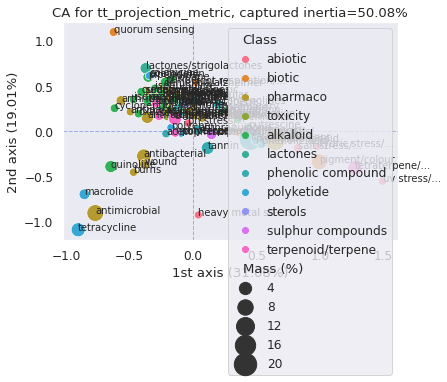

Drawing for row_implication_metric


<Figure size 432x288 with 1 Axes>

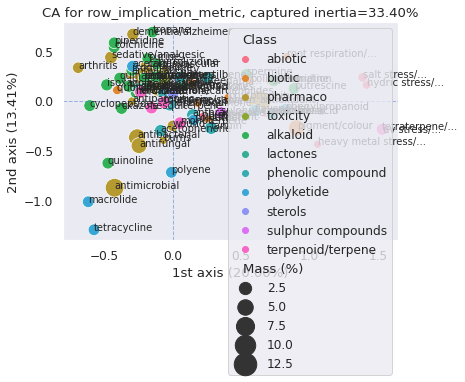

Drawing for col_implication_metric


<Figure size 432x288 with 1 Axes>

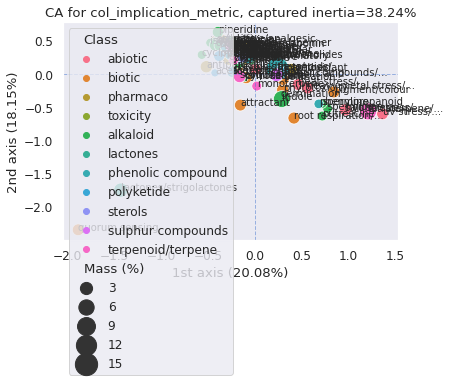

Drawing for fowlkes_mallows_metric


<Figure size 432x288 with 1 Axes>

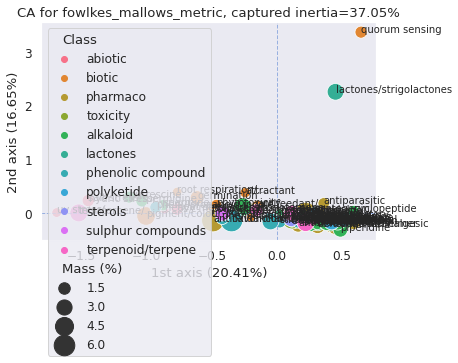

Drawing for fraction_metric


<Figure size 432x288 with 1 Axes>

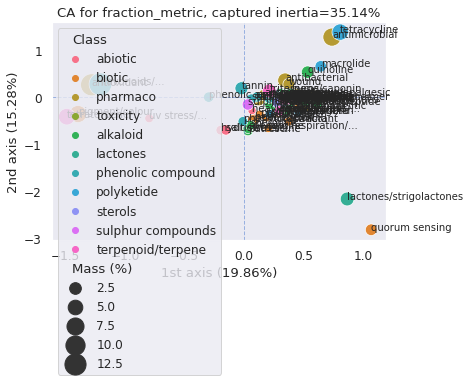

Drawing for odds_metric


<Figure size 432x288 with 1 Axes>

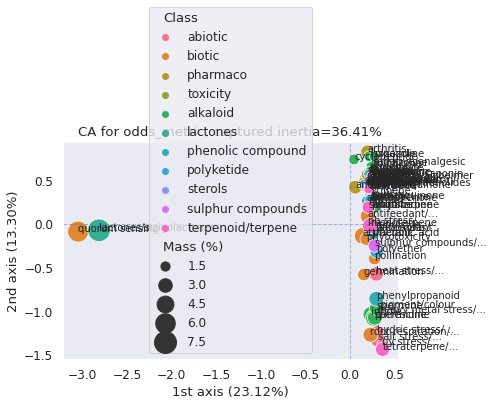

Drawing for accuracy_metric


<Figure size 432x288 with 1 Axes>

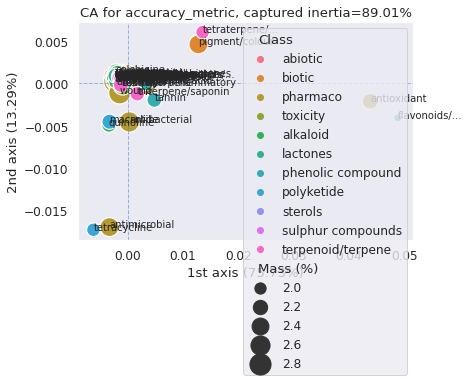

In [17]:
SHIFT = 0.0

for f_name, df in score_df.items() :#  [(x, y) for (x,y) in if "implication" not in f_name]:
    print(f"Drawing for {f_name}")
    ca = catk.ca.CA(SEED)
    ca.fit(df_shortener(df))
    res = ca.contributions(K=2)
    res["Class"] = [idx[0] for idx in res.index]
    axes = ca.axes()

    # its not meaning ful to draw both rows and cols for those metrics
    # if f_name == "row_implication_metric":
    #     res = res[res["Kind"] == "Compounds"]
    # if f_name == "col_implication_metric":
    #     res = res[res["Kind"] == "Activities"]

    x_axis = ("Coords (princ.)", 1)
    y_axis = ("Coords (princ.)", 2)
    ax = sns.scatterplot(data=res, x=x_axis, y=y_axis, hue="Class", size="Mass (%)", sizes=(64, 512))
    plt.axhline(y=0, linestyle="--", linewidth=1.0, alpha=0.5)
    plt.axvline(x=0, linestyle="--", linewidth=1.0, alpha=0.5)

    ax.set_title(f"CA for {f_name}, captured inertia={axes.loc[2, 'Cumulated (%)']:.2f}%")
    ax.set_xlabel(f"1st axis ({axes.loc[1, 'Inertia (%)']:.2f}%)")
    ax.set_ylabel(f"2nd axis ({axes.loc[2, 'Inertia (%)']:.2f}%)")
    for index, row in res.iterrows():
        ax.annotate(index[1], (row[x_axis] + SHIFT, row[y_axis] + SHIFT))
    plt.show()


## Implication rules

We summarize the top _k_ _row to col_ and _col to row_ implications.

In [13]:
def clean_implications(axis=0):
    if axis == 0:
        f_name = "row_implication_metric"
    elif axis == 1:
        f_name = "col_implication_metric"
    else:
        raise IndexError(f"no such axis {axis}")

    df = score_df[f_name].copy()
    df_support = (
        score_df["tt_projection_metric"]
        .melt(ignore_index=False, value_name="value")
        .reset_index()
        .drop(columns=["level_0", "variable_0"], axis=1)
        .rename(columns={"level_1": "compound", "variable_1": "activity"})
        .set_index(["compound", "activity"])
    )

    df.index = df.index.droplevel(0)
    df.columns = df.columns.droplevel(0)
    df = df.melt(ignore_index=False, value_name="%").reset_index()
    df.set_index(["index", "variable"], inplace=True)
    df.index.set_names(["compound", "activity"], inplace=True)
    df["mass"] = df_support["value"]
    # df["support"] = df_support["value"] / df["%"]
    df.sort_values(by="%", ascending=False, inplace=True)
    return df


# clean_implications(axis = 0)


For instance, the first line states that 75.8% of papers with keyword _phenolic acid_ also have the _antioxidant_ keywords: are 1879 papers with both keywords out of 1879 + 600 about _phenolic acid_.

In [14]:
NB_RULES_SHOWN = 20

print("Best implication rules : compound => activity")
display(clean_implications(0).head(NB_RULES_SHOWN))
print("phenolic acid/antioxidant submatrix")
display(dataset.loc[("phenolic compound", "phenolic acid"), ("pharmaco", "antioxidant")])


Best implication rules : compound => activity


,,%,mass
compound,activity,,
phenolic acid,antioxidant,0.718,6506
pyrrolizidine,toxicity,0.655,721
tetracycline,antimicrobial,0.619,22712
acetogenin,cytotoxicity,0.617,291
tetraterpene/carotenoid/xanthophyll,pigment/colour,0.605,22425
flavonoids/biflavonoids/anthocyanin,antioxidant,0.567,55613
polyene,antifungal,0.562,1772
macrolide,antimicrobial,0.496,7105
tannin,antioxidant,0.460,9333


phenolic acid/antioxidant submatrix


,w/o,w/
w/o,337770,93002
w/,2552,6506


Now, the other way around

In [15]:
print("Best implication rule : activity => compound")
clean_implications(1).swaplevel().head(NB_RULES_SHOWN)

Best implication rule : activity => compound


,,%,mass
activity,compound,,
quorum sensing,lactones/strigolactones,0.782,3592
root respiration/branching factors/root formation,indole,0.693,657
uv stress/light stress/uv tolerance/light tolerance/uv resistance/light resistance/uv impact/light impact/uv change/light change/irradiance,tetraterpene/carotenoid/xanthophyll,0.614,1436
antioxidant,flavonoids/biflavonoids/anthocyanin,0.559,55613
rheumatism,flavonoids/biflavonoids/anthocyanin,0.417,339
antidiabetic,flavonoids/biflavonoids/anthocyanin,0.401,3664
pigment/colour,tetraterpene/carotenoid/xanthophyll,0.394,22425
antimicrobial,tetracycline,0.387,22712
hydric stress/drought stress/hydric tolerance/drought tolerance/hydric resistance/drought resistance/hydric impact/drought impact/hydric change/drought change,tetraterpene/carotenoid/xanthophyll,0.350,884
